<center>
    <h1> Proyecto #2 - Métodos basados en transformadas de Fourier </h1>
    <h4 style="margin:10px;"> IPM-407 - Modelación Computacional con Algoritmos Rápidos </h4>
    <h3> Hernán Vargas -- 201073009-3 </h3>
    <h4 style="margin:5px;"> hernan.vargas@alumnos.usm.cl </h4>
</center>

*(Se recomienda la visualización de este documento en Jupyter Notebook 5.0, Kernel: Python 3.5.2)*

## Descripción
Consideren la siguiente ecuación de Poisson
$$
    \frac{\partial^2\phi}{\partial x^2} + \frac{\partial^2\phi}{\partial y^2} =
    \frac{1}{\pi^2} \Big[ 
        30 \Big( \big(\frac{x}{\pi}\big)^2 - \frac{x}{\pi}\Big) + 
        30 \Big( \big(\frac{y}{\pi}\big)^2 - \frac{y}{\pi}\Big) -
        4\pi^2 \big(\frac{x}{\pi} - 1 \big)\sin(2y)
    \Big]
$$
en el cuadrado $0 \leq x \leq \pi$ y $0 \leq y \leq \pi$ y con condiciones de contorno $\phi(0,y) = \phi(\pi,y) = \phi(x,0) = \phi(x,\pi)= 0$.

Resuelvan numéricamente esta ecuación usando:
1. Método espectral.
2. Diferencias finitas aceleradas con FFT en 2D (tipo pregunta 4 de la tarea 2).
3. Diferencias finitas aceleradas con FFT en 1D (tipo pregunta 5 de la tarea 2).

Para mallas de $N=[16,32,64,128]$ nodos (o más!).

En su informe, detalle la implemtación de cada técnica y discuta los siguientes puntos:
1. Convergencia del error.
2. Complejidad Algoritmica (N versus Tiempo).
3. Memoria utilizada.
4. Conclusiones con respecto a la conveniencia de cada caso.

La solución analitica de la ecuación es:

$$ \phi(x,y) = 
        15\Big(\big(\frac{x}{\pi}\big)^2-\frac{x}{\pi}\Big)\Big(\big(\frac{y}{\pi}\big)^2-\frac{y}{\pi}\Big) -
        \sin(2y)\frac{\sinh\big(2\pi(\frac{x}{\pi}-1)\big)}{\sinh(2\pi)} + 
        \Big(\frac{x}{\pi} - 1\Big)\sin(2y)
$$

**Ayuda:**
- Esta tarea está inspirada en el ejemplo del libro *fundamentals of Engineering Numerical Analysis* de Parviz Moin
- Las condiciones de borde homogénea $\phi=0$ en los bordes son concordantes con la función seno, por lo tanto es más conveniente usar la transformada del seno. Hay una implementación de transformada del seno en `scipy.fftpack`. Otra opción es calcular la transformada discreta del seno con la función proveída.
---

## Preliminares
Comenzamos importando las bibliotecas necesarias y definiendo las variables y funciones necesarias.

In [1]:
%load_ext memory_profiler
import gc
import numpy as np
import scipy
from scipy import sparse as sp;
from scipy.sparse import linalg as spla;
import matplotlib
import matplotlib.pyplot as plt
from dcst import * # http://www-personal.umich.edu/~mejn/computational-physics/dcst.py
plt.rcParams["figure.figsize"] = (12,4)

Y los parametros y funciones proveídas en el enunciado del proyecto.

In [2]:
#Función proveída en el proyecto
def dst_2D(x):
    M, N = np.shape(x)
    x = x[1:M-1,:]
    M,N = np.shape(x)
    y = np.zeros((2*(M+1),N))
    y[0,:] = np.zeros(N)[:]
    y[1:M+1,:] = x[:,:]
    y[M+1,:] = np.zeros(N)[:]
    y[M+2:2*M+ 2,:] = -np.flipud(x)[:,:]
    y_t = np.fft.fft(np.transpose(y))
    y_t = np.transpose(y_t)
    y = np.real((y_t[1:M+1])/(-1j*(M+1)))
    yy = np.zeros((M+2,N))
    yy[1:M+1,:] = y[:,:]
    return yy

#Considerando que la transformada inversa del seno es igual a la transformada del seno multiplicada por N/2
def idst_2D(x):
    r = dst_2D(x)
    return (r.shape[0]/2) * r

In [3]:
#Parametros generales.
pi = np.pi
N  = [16, 32, 64, 128, 192, 256]

Definimos la solución analitica como sigue:

In [4]:
sol = lambda x,y: 15*((x/pi)**2 - x/pi)*((y/pi)**2 - y/pi) \
                  - np.sin(2*y)*np.sinh(2*pi*((x/pi)-1))/np.sinh(2*pi) + np.sin(2*y)*((x/pi)-1)

Además podemos escribir la ecuación de Poisson del proyecto como:
$$ \frac{\partial^2\phi}{\partial x^2} + \frac{\partial^2\phi}{\partial y^2} = f(x,y) $$
$$  f(x,y) = \frac{1}{\pi^2} \Big[ 
        30 \Big( \big(\frac{x}{\pi}\big)^2 - \frac{x}{\pi}\Big) + 
        30 \Big( \big(\frac{y}{\pi}\big)^2 - \frac{y}{\pi}\Big) -
        4\pi^2 \big(\frac{x}{\pi} - 1 \big)\sin(2y)
    \Big]
$$
y creamos la función $f$:

In [5]:
f = lambda x,y: 30*((x/pi)**2 + (y/pi)**2 - (x/pi) - (y/pi))/(pi**2) - 4*np.sin(2*y)*((x/pi)-1)

Tambien necesitamos una función para evaluar dichas ecuaciones en mallas con un número arbitrario de puntos

In [6]:
def mk_grid(n, func, maxrg = np.pi):
    """ Crea una grilla de nxn puntos con la función evaluada.
    Argumentos:
        n     - Número de puntos por dimensión de la grilla.
        func  - Función a evaluar en cada punto.
        maxrg - (Opcional) rango máximo de la grilla, por defecto Pi.
    Retorna: Grilla de nxn con la función evaluada en cada punto."""
    x = np.linspace(0, maxrg, n)
    y = np.linspace(0, maxrg, n)
    return func(x[None,:], y[:,None])

---
## Métodos
Por las condiciones de borde del problema, los métodos implementados utilizand la transformada del seno.

### Método espectral
Sabemos que:
$$
    u_{mn}(x,y) = \sum_{j=1}^{M-1}\sum_{k=1}^{N-1} U_{jk}
    \sin\Big(\frac{\pi mj}{M}\Big)\sin\Big(\frac{\pi nk}{N}\Big) \qquad
    \text{con: } x=\frac{\pi m}{M}, \, y=\frac{\pi n}{N}
$$
Derivando tenemos:
$$
    \frac{\partial u_{mn}}{\partial x} = 
    \sum_{j=1}^{M-1}\sum_{k=1}^{N-1} -j U_{jk}
    \cos\Big(\frac{\pi mj}{M}\Big)\sin\Big(\frac{\pi nk}{N}\Big) 
$$
$$
    \frac{\partial^2 u_{mn}}{\partial x^2} = 
    \sum_{j=1}^{M-1}\sum_{k=1}^{N-1} -j^2U_{jk}
    \sin\Big(\frac{\pi mj}{M}\Big)\sin\Big(\frac{\pi nk}{N}\Big)
$$
Análogamente para las derivadas de $y$

Aplicando esto a nuestro problema (y cambiando de $\phi$ a $u$) tenemos:
$$ \frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2} = f(x,y) $$
$$  
    \sum_{j=1}^{M-1} \sum_{k=1}^{N-1} -j^2U_{jk} \sin\Big(\frac{\pi mj}{M}\Big)\sin\Big(\frac{\pi nk}{N}\Big) + 
    \sum_{j=1}^{M-1} \sum_{k=1}^{N-1} -k^2U_{jk} \sin\Big(\frac{\pi mj}{M}\Big)\sin\Big(\frac{\pi nk}{N}\Big) = 
    \sum_{j=1}^{M-1} \sum_{k=1}^{N-1} F_{jk} \sin\Big(\frac{\pi mj}{M}\Big)\sin\Big(\frac{\pi nk}{N}\Big)
$$
$$ -j^2U_{jk} -k^2U_{jk} = F_{jk} \implies U_{jk} = \frac{-1}{j^2 + k^2}F_{jk} $$

Como podemos notar, en $(0,0)$ la ecuación se indetermina, este termino lo podemos reemplazar por 0 debido a las condiciones de borde.

In [100]:
#Constante de nuestro problema para el método espectral.
spectral_const = lambda x,y: -1/(x**2 + y**2)
def spectral(f):
    """ Resuelve el problema propuesto por el método espectral.
    Argumentos:
        f -- Grilla con el lado derecho de la ecuación evaluada.
    Retorna: Grilla con la solución del problema en cada punto. """
    n = f.shape[0]
    F = dst2(f)
    C = mk_grid(n, spectral_const, n-1)
    C[0,0] = 0 # Por las condiciones de borde cambiamos el infinito a 0.
    u = idst2(F*C)
    #u[0,] = 0; u[-1,] = 0; u[:,0] = 0; u[:,-1] = 0; # Forzar los bordes a 0
    return u

### Diferencias finitas aceleradas con FFT en 2D
Usando diferencias finitas como es usual tenemos:
$$ \frac{\partial^2\phi}{\partial x^2} = \frac{\phi_{i-1,j} - 2 \phi_{i,j} + \phi_{i+1,j}}{\Delta x^2}$$
$$ \frac{\partial^2\phi}{\partial y^2} = \frac{\phi_{i,j-1} - 2 \phi_{i,j} + \phi_{i,j+1}}{\Delta y^2}$$
Nos queda:
$$  \frac{\phi_{i-1,j} - 2 \phi_{i,j} + \phi_{i+1,j}}{\Delta x^2} + 
    \frac{\phi_{i,j-1} - 2 \phi_{i,j} + \phi_{i,j+1}}{\Delta y^2} = f_{i,j}  $$

En particular, teniendo en consideración que $\Delta x^2 = \Delta y^2 = \Delta^2$, cambiando los indices de $i,j$ a $m,n$ (para no tener problemas con $i$ de los números imaginarios) y de $\phi$ a $u$ podemos escribir la ecuación como:
$$ u_{m-1,n} + u_{m+1,n} + u_{m,n-1} + u_{m,n+1} - 4u_{m,n} = \Delta^2 f_{m,n} $$

Como queremos aplicar la transformada del seno a esta ecuación, necesitamos saber como queda expresada para los valores desplazados:
$$
    u_{m\pm a,n\pm b} = 
    \sum_{j=1}^{M-1}\sum_{k=1}^{N-1} U_{jk}
        \sin\Big(\frac{\pi (m\pm a)j}{M}\Big)
        \sin\Big(\frac{\pi (n\pm b)k}{N}\Big) =
    \sum_{j=1}^{M-1}\sum_{k=1}^{N-1} U_{jk}
        \sin\Big(\frac{\pi mj}{M} \pm \frac{\pi aj}{M}\Big)
        \sin\Big(\frac{\pi nk}{N} \pm \frac{\pi bk}{N}\Big)
$$
Donde podemos utilizar $\sin(x\pm y) = \sin(x)\cos(y) \pm \cos(x)\sin(y)$.

Para el movimiento en el eje horizontal ($a=\pm 1, b=0$) los senos quedan:
\begin{align}
    u_{m-1,n} + u_{m+1,n} 
        &= \sin\Big(\frac{\pi nk}{N}\Big) \Big[
            \sin\Big(\frac{\pi mj}{M} - \frac{\pi j}{M}\Big) +
            \sin\Big(\frac{\pi mj}{M} + \frac{\pi j}{M}\Big)
        \Big] \\
        &= 2 \sin\Big(\frac{\pi nk}{N}\Big) \sin\Big(\frac{\pi mj}{M}\Big) \cos\Big(\frac{\pi j}{M}\Big)
\end{align}
Análogo para el eje vertical

Aplicando esto a nuestro problema y agrupando nos queda:
\begin{align}
    \sum_{j=1}^{M-1} \sum_{k=1}^{N-1} U_{jk} 
        \sin\Big(\frac{\pi mj}{M}\Big)\sin\Big(\frac{\pi nk}{N}\Big) 
        \Big[2\cos\Big(\frac{\pi j}{M}\Big) + 2\cos\Big(\frac{\pi k}{N}\Big) - 4 \Big] &= 
    \Delta^2\sum_{j=1}^{M-1} \sum_{k=1}^{N-1} F_{jk} 
        \sin\Big(\frac{\pi mj}{M}\Big)\sin\Big(\frac{\pi nk}{N}\Big) \\
    U_{jk} &=
    \frac{\Delta^2}{2\big(\cos\big(\frac{\pi j}{M}\big) + \cos\big(\frac{\pi k}{N}\big) - 2\big)} F_{jk}
\end{align}

In [101]:
def fast2d(f):
    """ Resuelve el problema propuesto por el método de diferencias
    finitas aceleradas por FFT en dos dimensiones.
    Argumentos:
        f -- Grilla con el lado derecho de la ecuación evaluada.
    Retorna: Grilla con la solución del problema en cada punto. """
    n = f.shape[0]
    delta = pi/n
    #Constante de nuestro problema para diferencias finitas aceleradas con FFT en 2D.
    const = lambda x,y: (delta**2)/(2*(np.cos(pi*x/n) + np.cos(pi*y/n) -2))
    F = dst2(f)
    C = mk_grid(n, const, n-1)
    C[0,0] = 0 # Por las condiciones de borde.
    u = idst2(F*C)
    #u[0,] = 0; u[-1,] = 0; u[:,0] = 0; u[:,-1] = 0; # Forzar los bordes a 0
    return u

#### Diferencias finitas aceleradas con FFT en 1D
La ecuación a resolver obtenida anteriormente es:
$$ u_{m-1,n} + u_{m+1,n} + u_{m,n-1} + u_{m,n+1} - 4u_{m,n} = \Delta^2 f_{m,n} $$
La transformada unidimensional desplazada queda como:
$$
    u_{m\pm a, n\pm b} = \sum_{j=1}^{M-1} U_{j,n\pm b}\sin\Big(\frac{\pi (m\pm a)j}{M}\Big)
$$

Análogamente al ejercicio anterior, podemos expresar los senos del eje horizontal como:
$$
    u_{m-1,n} + u_{m+1,n} = 2\sin\Big(\frac{\pi mj}{M}\Big)\cos\Big(\frac{\pi j}{M}\Big)
$$

Aplicando la transformada del seno a toda la ecuación y agrupando nos queda:
\begin{align}
    \sum_{j=1}^{M-1}\Bigg(
        U_{j,n-1} +
        \Big[2\cos\Big(\frac{\pi j}{M}\Big) -4 \Big] U_{j,n} +
        U_{j,n+1}
    \Bigg) \sin\Big(\frac{\pi mj}{M}\Big) &= 
    \Delta^2 \sum_{j=1}^{M-1} F_{jn} \sin\Big(\frac{\pi mj}{M}\Big) \\
    U_{j,n-1} + \Big[2\cos\Big(\frac{\pi j}{M}\Big) -4 \Big] U_{j,n} + U_{j,n+1} &= \Delta^2 F_{jn}
\end{align}
Obteniendo un sistema tridiagonal con el cual podemos resolver el problema.

In [9]:
def fast1d(f):
    """ Resuelve el problema propuesto por el método de diferencias
    finitas aceleradas por FFT en una dimensión, el cálculo .
    Argumentos:
        f -- Grilla con el lado derecho de la ecuación evaluada.
    Retorna: Grilla con la solución del problema en cada punto. """
    M     = f.shape[0]
    delta = pi/M
    d2F   = (delta**2) * dst_2D(f) #Transformada por fila * delta^2
    U     = np.zeros((M, M))
    for m in range(1,M-1): #Rango sin los bordes ya que valen 0
        ec = sp.diags([1, 2*np.cos(pi*m/M) - 4, 1], [-1, 0, 1], shape=(M-2,M-2), format="csr")
        U[m,1:-1] = spla.spsolve(ec, d2F[m,1:-1])
    return idst_2D(U) #Transformada inversa

----
## Experimentos
Se ejecutan los experimentos para las cantidades de nodos por dimensión requeridos. Primero se guarda en memoria los resultados análiticos para hacer la comparación y la parte derecha de la ecuación ya que en todos los casos es igual. Además se define la estructura donde se guardarán los resultados.

In [93]:
methods = {"sp": spectral, "2d": fast2d, "1d": fast1d }
colors  = {"sp": "r*--",   "2d": "go--", "1d": "b+--" }

In [11]:
data = {}
for key in methods:
    data[key] = {}
    for n in N:
        data[key][n] = {}

# Resultado análiticos:
data["real"] = {}
for n in N:
    data["real"][n] = {"result": mk_grid(n, sol)}

# Parte derecha de la ecuación:
rhs = {}
for n in N:
    rhs[n] = mk_grid(n, f)

Para evaluar la convergencia del error se define la siguiente función para calcularlo.

In [12]:
L2error = lambda w,u: np.sqrt(np.sum((w-u)**2)/np.sum(u**2))

Por último se ejecutan los experimentos

In [13]:
#Funciones para poder obtener la memoria y el tiempo de ejecución.
def run(method, array, dic):
    dic["result"] = method(array)

def mem(key, n):
    m = %memit -r 1 -o -q run(methods[key], rhs[n], data[key][n])
    data[key][n]["mem"] = max(m.mem_usage) - m.baseline

In [102]:
memtest = False
if memtest: gc.disable()

for key in methods:
    method = methods[key]
    for n in N:
        t = %timeit -r 1 -n 1 -o -q run(method, rhs[n], data[key][n])
        #t = %timeit -r 1 -n 1 -o -q mem(key, n)
        data[key][n]["time"] = t.best
        data[key][n]["error"] = L2error(data["real"][n]["result"], data[key][n]["result"])
        if memtest:
            m = %memit -r 1 -o -q run(method, rhs[n], data[key][n])
            data[key][n]["mem"] = max(m.mem_usage) - m.baseline
        else:
            data[key][n]["mem"] = 0

if memtest:
    gc.enable()
    gc.collect()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true

### Convergencia del error

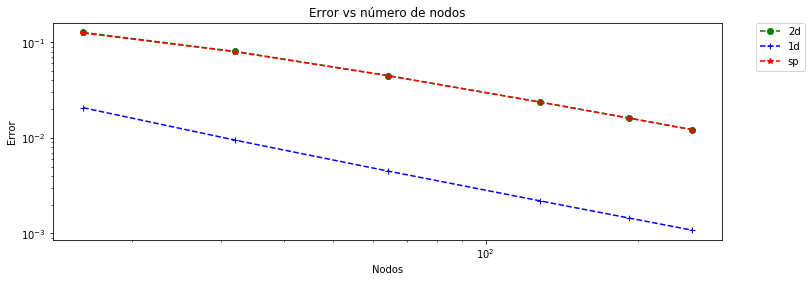

In [103]:
for key in methods:
    plt.plot(N, [data[key][_]["error"] for _ in N], colors[key], label=key);
plt.xlabel('Nodos')
plt.ylabel('Error')
plt.title('Error vs número de nodos')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.yscale('log')
plt.xscale('log');

plt.show();

Se nota claramente como el error del método acelerado en una dimensión es menor, aunque los tres decaen de la misma forma. El método espectral y el acelerado en dos dimensiones tienen resultados casi iguales.

### Complejidad Algoritmica

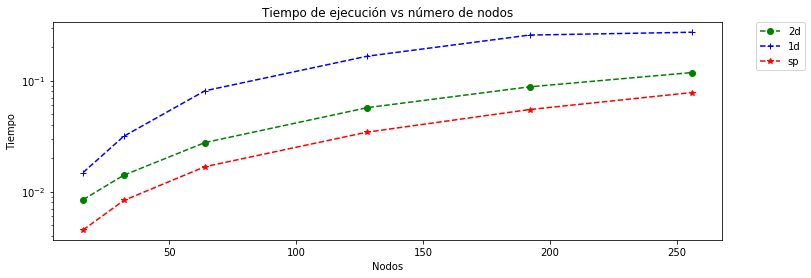

In [104]:
for key in methods:
    plt.plot(N, [data[key][_]["time"] for _ in N], colors[key], label=key);
plt.xlabel('Nodos')
plt.ylabel('Tiempo')
plt.title('Tiempo de ejecución vs número de nodos')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.yscale('log')
#plt.xscale('log');

plt.show();

Podemos notar como el método acelerado en una dimensión es el más lento de los tres, pero por los experimentos anteriores sabemos que se obtienen mejores resultados por lo que se puede considerar un *tradeoff*.

Por otro lado, notamos una rara intercepción entre el método espectral y el acelerado en dos dimensiones, por alguna razón el experimento del uso de memoria afecta estos resultados, comentando la línea 6 de la celda 14 (donde se realizan los experimentos), los resultados plasmados en este gráfico cambian, dejando al método espectral como el más rápido.

### Memoria utilizada

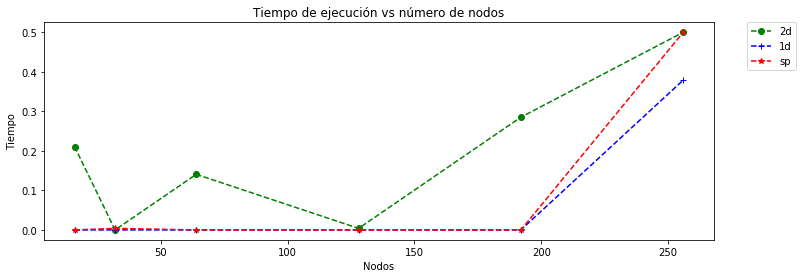

In [17]:
for key in methods:
    plt.plot(N, [data[key][_]["mem"] for _ in N], colors[key], label=key);
plt.xlabel('Nodos')
plt.ylabel('Tiempo')
plt.title('Tiempo de ejecución vs número de nodos')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.yscale('log')
#plt.xscale('log');

plt.show();

Como podemos notar, es dificil calcular el uso de memoria por medio de experimentos a pesar de tener desactivado el recolector de basura. Esto se debe a que python pide memoria al sistema, pero cuando la desocupa no la devuelve, por ello, el interprete requiere más memoria esta puede venir de lo liberado (del programa, pero no al sistema) o del sistema (cuando el programa no tiene más memoria sin usar).

Analizando los algoritmos podemos obtener una aproximación de su uso de memoria. Debemos tener en cuenta que las implementaciones de este proyecto no incluyen la matriz con el lado derecho de la ecuación.

Supongamos que resolvemos para una matriz de $n\times n$ elementos, los métodos implementados utilizan:

**Método espectral:**
- $1$ `int` ($n$)
- $4n^2$ `float64` (4 matrices $n\times n$: `F`, `C`, `u`, `U`)
- Un total de $(32n^2 + 4)$ bytes

**Método Diferencias Finitas acelerado por FFT en 2D:**
- $1$ `int` ($n$)
- $1$ `float64` ($\Delta^2$)
- $4n^2$ `float64` (4 matrices $n\times n$: `F`, `C`, `u`, `U`)
- Un total de $(32n^2 + 12)$ bytes

**Método Diferencias Finitas acelerado por FFT en 1D:**
- $1$ `int` ($n$)
- $1$ `float64` ($\Delta^2$)
- $3n^2$ `float64` (4 matrices $n\times n$: `F`, `C`, `u`, `U`)
- $3(n-2)$ `float64` (sistema tridiagonal de $(n-2)\times (n-2)$)
- Un total de  $(24n^2 +24n -4)$ bytes

----
## Concluciones

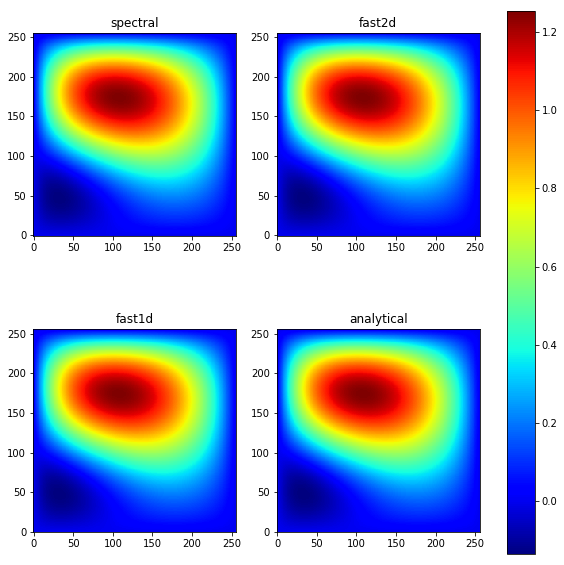

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes[0][0].imshow(data['sp'][256]["result"], cmap="jet", origin="lower")
axes[0][0].set_title("spectral")
axes[0][1].imshow(data['2d'][256]["result"], cmap="jet", origin="lower")
axes[0][1].set_title("fast2d")
axes[1][0].imshow(data['1d'][256]["result"], cmap="jet", origin="lower")
axes[1][0].set_title("fast1d")
im = axes[1][1].imshow(data['real'][256]["result"], cmap="jet", origin="lower")
axes[1][1].set_title("analytical")

fig.colorbar(im, ax=axes.ravel().tolist());
plt.show();

Los tres algoritmos implementados son batante buenos para la resolución del problema. 
Algunos puntos a destacar por algoritmo son los siguientes:

#### Método espectral
Deberíamos usar este método cuando la ecuación a resolver no tenga problemas en sus derivadas y las condiciones de borde lo permitan.

**Pros:**
- Facil de implementar.
- El error debería disminuir espectralmente.

**Contras:**
- No se logró que el error presentara una disminución espectral al número de nodos.
- Requiere calcular las derivadas de la transformada.
- Si las condiciones de borde no son ideales el problema se complica notablemente.

#### Método Diferencias Finitas acelerado por FFT en 2D
Podríamos usar este método si no podemos usar el método espectral.

**Pros:**
- Fácil de implementar.

**Contras:**
- El error disminuye linealmente.
- Si las condiciones de borde no son ideales el problema se complica.

#### Método Diferencias Finitas acelerado por FFT en 1D
Deberíamos usar este método si el tiempo de calculo no es un problema y queremos buenos resultados con menos nodos.

**Pros:**
- Fácil de implementar.
- Se obtienen los resultados con menor error por número de nodos.
- El código es el más eficiente en el consumo de memoria.

**Contras:**
- Requiere la resolución de un sistema tridiagonal por linea/columna.
- Es más lento que los métodos anteriores.
- El error disminuye linealmente.

Teoricamente el método espectral debería ser el más adecuado para resolver problemas como el propuesto, pero por algún error en la implementación no se logró la eficiencia esperada. De los códigos precentados en este informe, diferencias finitas aceleradas en una dimensión parece ser el más adecuado para la resolución del problema.

---